## The objective of this project is to mimic the behavior of a human driver and clone it using a Convolutional Neural Network, so that the car can drive autonomously. The behavior of the human driver is captured by collecting data using Udacity's simulator on a track. 

#### The data collection process: The simulator has a car with three front-facing cameras that captures images: one each for left, center, and right views respectively. It also outputs a CSV file that has six columns: 
##### Column 1: Image path for center image
##### Column 2: Image path for left image
##### Column 3: Image path for right image
##### Column 4: Steer angle
##### Column 5: Throttle
##### Column 6: Brake

#### I used the data provided by Udacity for a few tracks, and recorded some additional data on my own using the simulator as well. The following files are relevant for this project: 
##### --BehaviorClone.ipynb(Jupyter notebook with all comments for the report)
##### --drive.py (script to drive the car)
##### --model.h5 (a trained Keras model)
##### --README.md (a markdown report writeup file)
##### --[Video](https://youtu.be/ap68tlotoPk)

#### The following directories are relevant for this project:
#### ./Misc4Report - Images and other files that are used in the report

#### To train the model, run the following command: python Clone.py
#### To run the model on the simulator, run the following command: python drive.py model.h5

## Python code for the behavioral clone model

### Import the necessary packages

In [1]:
import csv
import cv2
import numpy as np
import keras
import os
import sklearn
import math
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Flatten, Dense, Lambda, Cropping2D, Input, ELU
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam
from sklearn.utils import shuffle


Using TensorFlow backend.


## Step 1: Load the data

Total # of images: 29997
Total # of steering angles: 29997
Original Image Shape: (160, 320, 3)
Cropped Image Shape: (70, 320, 3)


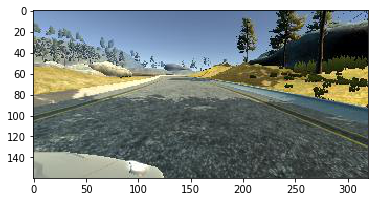

In [2]:
lines_ud = []
images = []
steerings = []
# Add/subtract a steering correction factor for the left and right cameras because of the camera perspective
correction = 0.2

# Load Udacity's track Data
with open('./Udacity_Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines_ud.append(line)

# Load each row into line
for line in lines_ud:
# Load the center, left & right images
    for i in range(3):
        source_path = line[i]
        tokens = source_path.split('/')
        filename = tokens[-1]
        local_path = './Udacity_Data/IMG/' + filename
        image = cv2.imread(local_path)
        #crop the image to remove everything above the horizon & remove the hood
        #of the car at the bottom of the image
        cropped = image[65:135,:,:]
        images.append(cropped)
    steering = float(line[3])
    steerings.append(steering)
    steerings.append(steering+correction)
    steerings.append(steering-correction)


# Load My track Data
lines_my = []
with open('./My_Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines_my.append(line)
 
# Load each row into line
for line in lines_my:
# Load the center, left & right images 
    for i in range(3):
        # Load the center, left & right images
        source_path = line[i]
        tokens = source_path.split('/')
        filename = tokens[-1]
        local_path = './My_Data/IMG/' + filename
        image = cv2.imread(local_path)
        #crop the image to remove everything above the horizon & remove the hood
        #of the car at the bottom of the image
        cropped = image[65:135,:]
        images.append(cropped)
    steering = float(line[3])
    steerings.append(steering)
    steerings.append(steering+correction)
    steerings.append(steering-correction)

# Converting images & steering angles to numpy arrays
images = np.array(images)
steerings = np.array(steerings)

# Print a summary of total number of images and steering angles
print ("Total # of images:", len(images))
print ("Total # of steering angles:", len(steerings))
print ("Original Image Shape:", image.shape)
print ("Cropped Image Shape:", images[0].shape)

# Print an example image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
## Some useful functions

In [4]:
# Function to visualize images
def plot_row_col(rows,cols,X,y):
    plt.figure(figsize = (15,5))
    grid = gridspec.GridSpec(rows,rows)
    # set the spacing between axes.
    grid.update(wspace=0.5, hspace=1)  

    for i in range(rows*cols):
        img_plt = plt.subplot(grid[i])
        plt.axis('on')
        img_plt.set_xticklabels([])
        img_plt.set_yticklabels([])
        img_plt.set_aspect('equal')
        index = np.random.randint(0,len(X))
        plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB))
        plt.title('Steer angle:' + str(np.round(y[index],4)))
        plt.axis('off')
    plt.show()

# Function to add random brightness to images
def add_random_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

# Inspired by [Vivek's article](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9)
# Function to randomly shift the image horizontally and vertically along with steering angles to simulate a car's position
# at various points on the track
def trans_image(image,steer,trans_range):
    rows, cols, _ = image.shape
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 10*np.random.uniform()-10/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    return image_tr,steer_ang,tr_x

def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

def process_image(image, steering):
    #Process images to randomly adjust brightness & transform the images
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,steering,tr_x = trans_image(image,steering,150)
    image = add_random_brightness(image)
    #Add random shadows to a 3rd of the images 
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = add_random_shadow(image)
    toss_coin = random.randint(0,1)
    #Flip half of the images
    if toss_coin == 1:
        image = cv2.flip(image,1)
        steering = steering * -1.0
    return image, steering


## Step 2: Explore, Augment, & Visualize the data

#### Visualize the input images. Note that all images are cropped to the region of interest. The data above the horizon (top 65 rows of the image)  does not have any relevant data and is cropped as a result. Similarly, the bottom 25 rows of the image are removed since it has the hood of the car which is irrelevant.

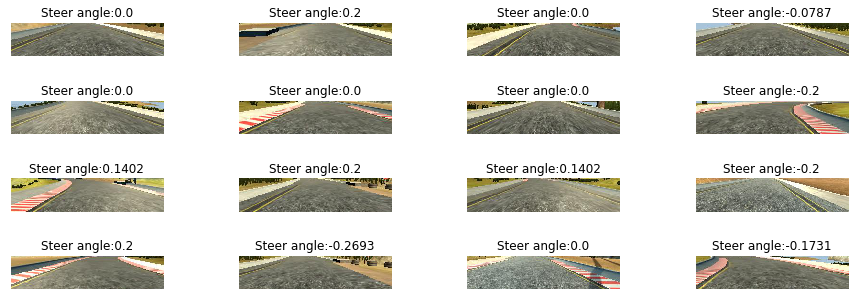

In [5]:
import matplotlib.gridspec as gridspec

plot_row_col(4,4,images,steerings)

#### Random brightness is added the images in the "process_image" function so that the CNN model can be trained to drive in different lighting conditions on the track. 

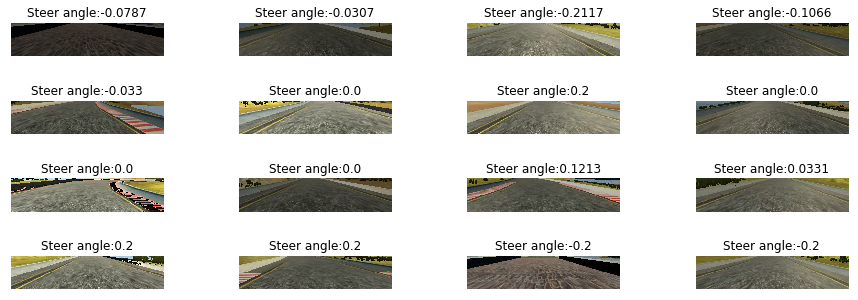

In [6]:
# Visualize brightness augmentation images
plt.figure(figsize = (15,5))
grid = gridspec.GridSpec(4,4)
# set the spacing between axes.
grid.update(wspace=0.5, hspace=1)  

for i in range(4*4):
    img_plt = plt.subplot(grid[i])
    plt.axis('on')
    img_plt.set_xticklabels([])
    img_plt.set_yticklabels([])
    img_plt.set_aspect('equal')
    index = np.random.randint(0,len(images))
    disp_image = cv2.cvtColor(images[index],cv2.COLOR_BGR2RGB)
    rand_bright = add_random_brightness(disp_image)
    plt.imshow(rand_bright)
    plt.title('Steer angle:' + str(np.round(steerings[index],4)))
    plt.axis('off')
plt.show()

#### Random transformations are added to the images so that the CNN model can be trained to drive the car while it is at different positions on the track. The input image is randomly shifted horizontally and vertically by a few pixels. The steering angle is also shifted accordingly to adjust for the shifts. This augmentation feature is coded into the process_image function.

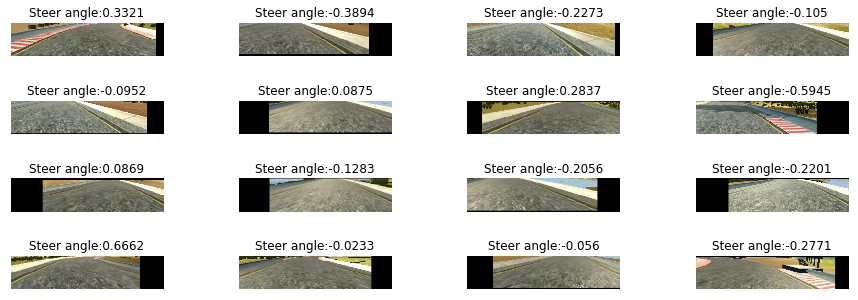

In [7]:
# Visualize images after adding transformations
plt.figure(figsize = (15,5))
grid = gridspec.GridSpec(4,4)
# set the spacing between axes.
grid.update(wspace=0.5, hspace=1)  

for i in range(4*4):
    img_plt = plt.subplot(grid[i])
    plt.axis('on')
    img_plt.set_xticklabels([])
    img_plt.set_yticklabels([])
    img_plt.set_aspect('equal')
    index = np.random.randint(0,len(images))
    disp_image = cv2.cvtColor(images[index],cv2.COLOR_BGR2RGB)
    Ximage,Xstr,tr_x = trans_image(disp_image,steerings[index],150)
    plt.imshow(Ximage)
    plt.title('Steer angle:' + str(np.round(Xstr,4)))
    plt.axis('off')
plt.show()

#### There are a number of shadows on the track because of trees. I applied random shadows to a third of the input images such that the CNN model is trained to account for shadows on the track. The car also drives left most of the time on track 1 and this would skew the CNN model by training a bias into it to drive left. To account for this bias, the input images are flipped horizontally 50% of the time along with the steering angle. Both of these data augmentation features are coded into the "process_image" function.

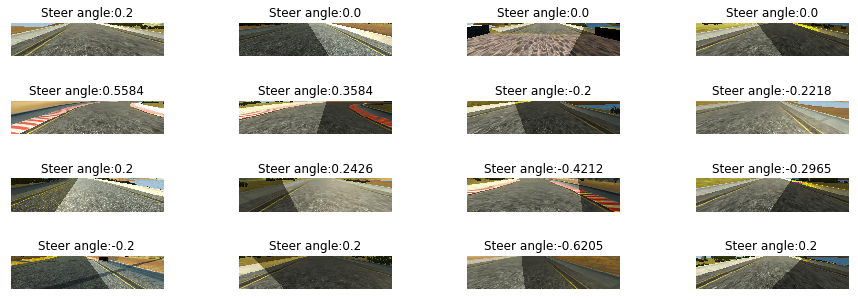

In [8]:
# Visualize images after adding random shadows
plt.figure(figsize = (15,5))
grid = gridspec.GridSpec(4,4)
# set the spacing between axes.
grid.update(wspace=0.5, hspace=1)  

for i in range(4*4):
    img_plt = plt.subplot(grid[i])
    plt.axis('on')
    img_plt.set_xticklabels([])
    img_plt.set_yticklabels([])
    img_plt.set_aspect('equal')
    index = np.random.randint(0,len(images))
    disp_image = cv2.cvtColor(images[index],cv2.COLOR_BGR2RGB)
    shadow_img = add_random_shadow(disp_image)
    plt.imshow(shadow_img)
    plt.title('Steer angle:' + str(np.round(steerings[index],4)))
    plt.axis('off')
plt.show()

#### A histogram showing the distribution of steering angle data is plotted to explore how the data looks like, and to determine what the next steps should be to process the data.

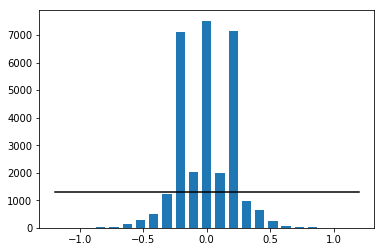

In [9]:
# Plot a histogram of all the steering angles
num_bins = 23
avg_samples_per_bin = len(steerings)/num_bins
hist, bins = np.histogram(steerings, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(steerings), np.max(steerings)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()


## Step 3: Process the data to feed to the CNN model

### Some of the steering angles are over-represented in the data as seen in the previous histogram. This causes a bias in the CNN model's results which will be skewed towards the over-represented data. To ensure a uniform distribution of the data, some of the over-represented data is removed with high probability

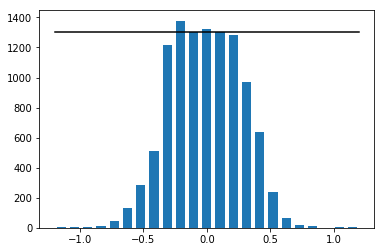

In [10]:
keep_probs = []
target = avg_samples_per_bin

for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(steerings)):
    for j in range(num_bins):
        if steerings[i] > bins[j] and steerings[i] <= bins[j+1]:
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
images = np.delete(images, remove_list, axis=0)
steerings = np.delete(steerings, remove_list)

# print histogram again to check for data uniformity
hist, bins = np.histogram(steerings, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(steerings), np.max(steerings)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

### Split the dataset into training and validation datasets (85/15 split)

In [11]:
Xt_Images, Xv_Images, yt_angles, yv_angles = train_test_split(images, steerings, test_size=0.15, random_state=1)

### Print a Summary of the data after ensuring data uniformity, and splitting into training & validation datasets

In [12]:
print ("Total # of images after removing bias:", len(images))
print ("Total # of steering angles after removing bias:", len(steerings))
print ("Image shape:", Xt_Images[0].shape)
print ("# of Training images:", len(Xt_Images))
print ("# of Training steering angles:", len(yt_angles))
print ("# of Validation images:", len(Xv_Images))
print ("# of Validation steering angles:", len(yv_angles))

Total # of images after removing bias: 10780
Total # of steering angles after removing bias: 10780
Image shape: (70, 320, 3)
# of Training images: 9163
# of Training steering angles: 9163
# of Validation images: 1617
# of Validation steering angles: 1617


## Step 4: Select the CNN model along with the hyperparameters
### I used an adaptation of [Nvidia's CNN model's]  (https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) to network architecture to accomplish the objective of this project. The detailed architecture of this network is shown in the figure below along with the activations and L2 regularizations on each layer:

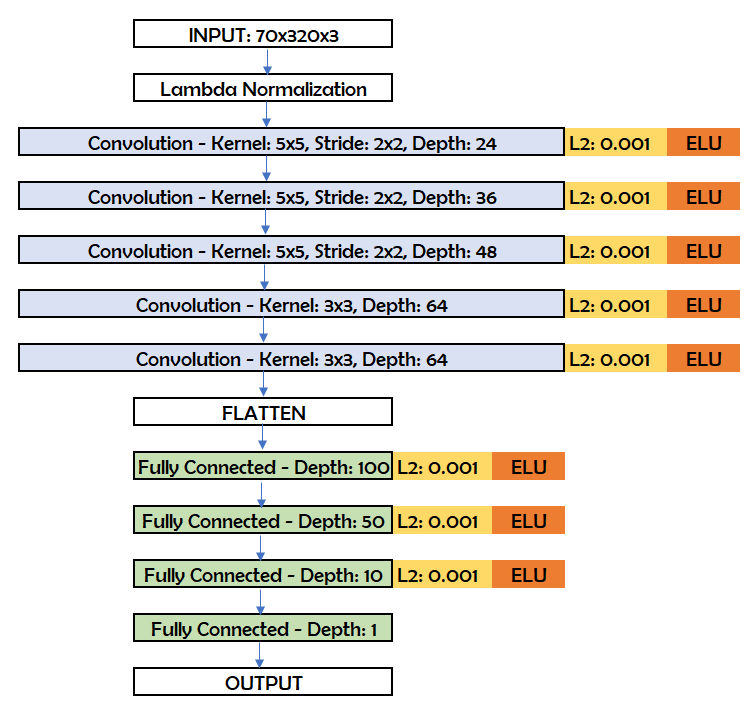

In [13]:

input_shape = Xt_Images[0].shape
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5,input_shape=input_shape))
model.add(Conv2D(24,5,5,subsample=(2,2)))
model.add(ELU())
model.add(Conv2D(36,5,5,subsample=(2,2)))
model.add(ELU())
model.add(Conv2D(48,5,5,subsample=(2,2)))
model.add(ELU())
model.add(Conv2D(64,3,3))
model.add(ELU())
#model.add(Dropout(.5))
model.add(Conv2D(64,3,3))
model.add(ELU())
#model.add(Dropout(.5))
model.add(ELU())
model.add(Flatten())
#model.add(Dropout(.5))

#model.add(Dense(1164, W_regularizer = l2(0.001)))
#model.add(ELU())
#model.add(Dropout(.5))

model.add(Dense(100, W_regularizer = l2(0.001)))
model.add(ELU())
#model.add(Dropout(.5))

model.add(Dense(50, W_regularizer = l2(0.001)))
model.add(ELU())
#model.add(Dropout(.5))

model.add(Dense(10, W_regularizer = l2(0.001)))
model.add(ELU())
#model.add(Dropout(.5))

model.add(Dense(1))


### Generator Functions: Instead of storing the preprocessed data in memory all at once, I used generator functions to pull pieces of the data and process them on the fly as needed, for better memory-efficiency.

In [14]:
batchsz = 64

def generator(lcr_images, str_angles, batch_size=batchsz):
    batch_images = np.zeros((batch_size, 70, 320, 3))
    batch_steerings = np.zeros(batch_size)
    while True: # Loop forever so the generator never terminates
        shuffle(lcr_images, str_angles)
        for i in range(batch_size):
            i_rand = np.random.randint(len(lcr_images)-1)
            X, y = process_image(lcr_images[i_rand], str_angles[i_rand])
            batch_images[i] = X
            batch_steerings[i] = y
        yield batch_images,batch_steerings

def val_generator(lcr_images, str_angles, batch_size=batchsz):
    num_samples = len(lcr_images)
    while 1: # Loop forever so the generator never terminates
        shuffle(lcr_images, str_angles)
        for offset in range(0, num_samples, batch_size):
            batch_images = lcr_images[offset:offset+batch_size]
            batch_angles = str_angles[offset:offset+batch_size]
            X_train = np.array(batch_images)
            y_train = np.array(batch_angles)
            yield shuffle(X_train, y_train)


## Step 5: Compile, run & save the model

### I used 10 epochs for training,  a batch size of 64, and compiled the model with the adam optimizer to calculate the lowest mean-squared-error of the steering angle.

In [15]:
train_generator = generator(Xt_Images, yt_angles, batch_size=batchsz)
validation_generator = val_generator(Xv_Images, yv_angles, batch_size=batchsz)

model.compile(optimizer='adam', loss='mse')

model.fit_generator(train_generator, samples_per_epoch=(len(Xt_Images)//batchsz)*batchsz, 
            nb_epoch=10, validation_data=validation_generator, nb_val_samples=len(Xv_Images))

#Print the summary of the model
print(model.summary())

# Save model data
model.save('./model.h5')

Epoch 1/10
9152/9152 [==============================] - 47s - loss: 0.4026 - val_loss: 0.6227
Epoch 2/10
9152/9152 [==============================] - 45s - loss: 0.2795 - val_loss: 0.7811
Epoch 3/10
9152/9152 [==============================] - 44s - loss: 0.2266 - val_loss: 0.7162
Epoch 4/10
9152/9152 [==============================] - 45s - loss: 0.1884 - val_loss: 0.3420
Epoch 5/10
9152/9152 [==============================] - 45s - loss: 0.1568 - val_loss: 0.1520
Epoch 6/10
9152/9152 [==============================] - 44s - loss: 0.1304 - val_loss: 0.1292
Epoch 7/10
9152/9152 [==============================] - 43s - loss: 0.1120 - val_loss: 0.1063
Epoch 8/10
9152/9152 [==============================] - 45s - loss: 0.0970 - val_loss: 0.0991
Epoch 9/10
9152/9152 [==============================] - 45s - loss: 0.0873 - val_loss: 0.0827
Epoch 10/10
9152/9152 [==============================] - 43s - loss: 0.0778 - val_loss: 0.0880
___________________________________________________________

## Summary:
### The car drives fine on track 1 as evident in the [video](https://youtu.be/ap68tlotoPk) file. However, for track 2 the results are inconsistent. Even if I run the same model multiple times, I get different results on track 2. This must be because of the model weights initialization being different for every run, resulting in different convergences for a varying final result. I would like to revisit this project at some point in the future to ensure that the model weights initialization are consistent. In some cases, I have seen the car drive halfway on track 2 and crash at a sharp turn. In other cases, I have seen that the car crashes at the beginning of the track. 

### I would also like to add more data for sharp turns so that the model can be trained better for these situations. Also, track 2 has a divider lane and I would like to generate data with divider lanes so that the car can stay within the lane in track2 as well. With additional model tuning using relevant data and further experimentation with the hyperparameters, this model can be generalized to work with other tracks as well.